In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-03 10:54:22--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.01s   

2023-10-03 10:54:22 (145 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [3]:
keep = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = pd.read_csv('data.csv')
df = df[keep]
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.fillna(0, inplace=True)
average_msrp = df['msrp'].mean()
df['above_average'] = (df['msrp'] > average_msrp).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average
y_val = df_val.above_average
y_test = df_test.above_average

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [5]:
numerical=df_train.select_dtypes(include=['number']).columns.tolist()
categorical= df_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [6]:
for var in numerical:
    auc = roc_auc_score(y_train, df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    print('%9s, %.3f' % (var, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673


In [7]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
auc=roc_auc_score(y_val, y_pred)
print(f'AUC: {auc:.3f}')

AUC: 0.980


In [8]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9150615600398313

In [9]:
precisions = []
recalls = []

thresholds = np.arange(0, 1.01, 0.01)

for threshold in thresholds:

    y_pred_bin = (y_pred >= threshold).astype(int)

    precision = precision_score(y_val, y_pred_bin)
    recall = recall_score(y_val, y_pred_bin)

    precisions.append(precision)
    recalls.append(recall)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


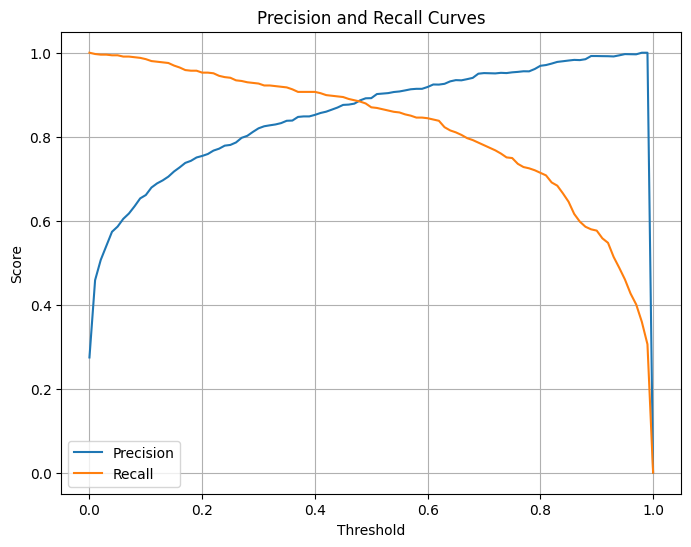

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)

plt.show()

In [11]:
f1_scores = []
thresholds = np.arange(0, 1.01, 0.01)
for threshold in thresholds:

    y_pred_binary = (y_pred >= threshold).astype(int)


    f1 = f1_score(y_val, y_pred_binary)


    f1_scores.append(f1)


max_f1_threshold = thresholds[np.argmax(f1_scores)]



Threshold where F1 score is maximal: 0.49


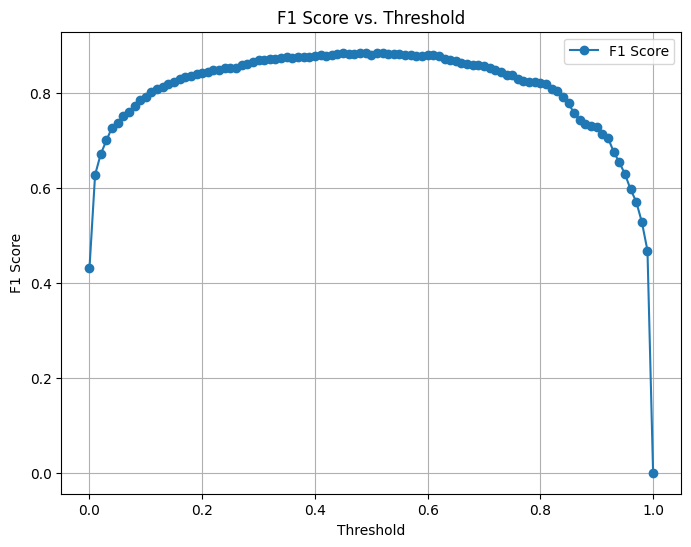

In [12]:
print(f'Threshold where F1 score is maximal: {max_f1_threshold:.2f}')
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical+categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[numerical+categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [14]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.5f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.00206


In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for c in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.003
C= 0.1, 0.972 +- 0.002
C=   1, 0.979 +- 0.002
C=  10, 0.981 +- 0.003
